# Forecasting using Autogluon

## Preparing the Dataset

Let's take a look first at the raw data:

In [9]:
%load_ext autoreload
%autoreload 2

import os
WORKING_DIRECTORY: str = "/Users/cgavidia-calderon/Documents/GitHub/OpenMarsML/dust_forecast"
os.chdir(WORKING_DIRECTORY)

import logging
logging.basicConfig(level=logging.INFO)

from data_utils import DATETIME_COLUMN
import pandas as pd
TRAINING_DATA_FILE: str = "/Users/cgavidia-calderon/Documents/GitHub/OpenMarsML/data/data_files/insight_openmars_training_time.csv"


training_dataframe: pd.DataFrame = pd.read_csv(TRAINING_DATA_FILE, parse_dates=[DATETIME_COLUMN])
training_dataframe


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,Time,Ls,LT,Tsurf,Psurf,CO2ice,cloud,vapour,u_wind,v_wind,dust,temp
0,1998-07-15 21:23:39,0.555,9.0,264.042,721.113,0.0,0.092,0.027,-7.451,8.604,0.428,179.686
1,1998-07-15 23:26:53,0.598,11.0,274.736,705.090,0.0,0.145,0.026,-7.053,4.934,0.427,174.502
2,1998-07-16 01:30:07,0.640,13.0,265.939,700.691,0.0,0.105,0.026,-6.825,-0.063,0.427,173.429
3,1998-07-16 03:33:21,0.683,15.0,238.624,697.252,0.0,0.134,0.025,-5.373,-4.048,0.426,173.556
4,1998-07-16 05:36:35,0.725,17.0,213.634,717.146,0.0,0.139,0.026,-3.899,-3.133,0.426,174.789
...,...,...,...,...,...,...,...,...,...,...,...,...
72191,2015-06-18 04:24:40,359.795,7.0,235.054,730.498,0.0,0.019,0.014,1.868,8.633,0.388,191.498
72192,2015-06-18 06:27:53,359.838,9.0,264.949,730.753,0.0,0.015,0.014,-6.924,6.590,0.388,187.591
72193,2015-06-18 08:31:07,359.880,11.0,275.776,703.987,0.0,0.012,0.014,-4.681,2.727,0.388,185.172
72194,2015-06-18 10:34:21,359.923,13.0,266.946,695.836,0.0,0.012,0.014,-3.277,-5.484,0.388,184.216


In [10]:
training_dataframe.describe()

,Time,Ls,LT,Tsurf,Psurf,CO2ice,cloud,vapour,u_wind,v_wind,dust,temp
count,72196,72196.000000,72196.000000,72196.000000,72196.000000,72196.0,72196.000000,72196.000000,72196.000000,72196.00000,72196.000000,72196.000000
mean,2006-12-31 17:25:41.788063232,169.699903,12.000000,221.822267,731.683035,0.0,0.038435,0.015826,0.220215,1.44027,0.457868,184.425504
min,1998-07-15 21:23:39,0.000000,1.000000,179.021000,593.572000,0.0,0.000000,0.002000,-18.546000,-20.31800,0.000000,144.080000
25%,2002-10-08 06:05:25,78.234000,7.000000,195.718000,696.571000,0.0,0.000000,0.013000,-2.480000,-1.61825,0.216000,175.625750
50%,2006-12-31 17:47:42,159.002500,12.000000,209.725500,738.898000,0.0,0.011000,0.015000,0.807000,1.52050,0.346000,184.401000
75%,2011-03-26 04:43:14,261.545750,17.000000,248.303250,767.305250,0.0,0.055000,0.018000,2.405000,4.18100,0.544000,194.807250
max,2015-06-18 12:37:35,359.992000,23.000000,289.984000,841.617000,0.0,0.863000,0.038000,17.213000,17.50300,5.333000,242.430000
std,NaN,105.241749,6.903982,30.912305,47.995385,0.0,0.060889,0.004600,4.060972,4.91390,0.439075,14.658462


We have data from 1998 to 2015. Not sure if its evenly sampled though. Let's try to transform this to wide format:

In [11]:
from data_utils import to_wide_format

wide_training_dataframe: pd.DataFrame = to_wide_format(training_dataframe, time_column=DATETIME_COLUMN)
wide_training_dataframe

INFO:root:Metric: Ls Time steps: 72196
INFO:root:Metric: LT Time steps: 72196
INFO:root:Metric: Tsurf Time steps: 72196
INFO:root:Metric: Psurf Time steps: 72196
INFO:root:Metric: CO2ice Time steps: 72196
INFO:root:Metric: cloud Time steps: 72196
INFO:root:Metric: vapour Time steps: 72196
INFO:root:Metric: u_wind Time steps: 72196
INFO:root:Metric: v_wind Time steps: 72196
INFO:root:Metric: dust Time steps: 72196
INFO:root:Metric: temp Time steps: 72196
INFO:root:Number of metrics: 11


,Time,target,Metric
0,1998-07-15 21:23:39,0.555,Ls
1,1998-07-15 23:26:53,0.598,Ls
2,1998-07-16 01:30:07,0.640,Ls
3,1998-07-16 03:33:21,0.683,Ls
4,1998-07-16 05:36:35,0.725,Ls
...,...,...,...
72191,2015-06-18 04:24:40,191.498,temp
72192,2015-06-18 06:27:53,187.591,temp
72193,2015-06-18 08:31:07,185.172,temp
72194,2015-06-18 10:34:21,184.216,temp


11 time series, and 70K time steps. If recall correctly, data is sampled every two hours.

## Attempting a Forecast

First, let's create a `TimeSeriesDataFrame` instance. We are not including static features per time series.

In [12]:
from autogluon.timeseries import TimeSeriesDataFrame
from data_utils import METRIC_COLUMN, DATETIME_COLUMN

FREQUENCY: str = "2H"
PREDICTION_LENGTH: int = 10
PATH: str = "autogluon-openmars-2H"
EVALUATION_METRIC: str = "MASE"
PRESETS: str = "best_quality"
TIME_LIMIT: int = 4 * 60 * 60

time_series_dataframe: TimeSeriesDataFrame = TimeSeriesDataFrame.from_data_frame(
    wide_training_dataframe,
    id_column=METRIC_COLUMN,
    timestamp_column=DATETIME_COLUMN,
)

time_series_dataframe = time_series_dataframe.convert_frequency(freq=FREQUENCY)

training_time_series, testing_time_series = time_series_dataframe.train_test_split(PREDICTION_LENGTH)

training_time_series

target
item_id timestamp                   
Ls      1998-07-15 20:00:00    0.555
        1998-07-15 22:00:00    0.598
        1998-07-16 00:00:00    0.640
        1998-07-16 02:00:00    0.683
        1998-07-16 04:00:00    0.725
...                              ...
temp    2015-06-17 08:00:00  186.714
        2015-06-17 10:00:00  188.496
        2015-06-17 12:00:00      NaN
        2015-06-17 14:00:00  187.265
        2015-06-17 16:00:00  187.394

[815881 rows x 1 columns]

Now, let's create the predictor instance. The ``NN5 Daily`` dataset has 111 time series with 80K time steps, and the prediction length is 56. Also the ``CIF 2016`` dataset has 72 time series and 6K time steps has a prediction length of 12. 

Let's start with 10.

In [13]:
from autogluon.timeseries import TimeSeriesPredictor

time_series_predictor: TimeSeriesPredictor = TimeSeriesPredictor(
    prediction_length=PREDICTION_LENGTH,
    eval_metric=EVALUATION_METRIC
    # path=PATH,
)
    
time_series_predictor.fit(
    training_time_series,
    presets=PRESETS,
    time_limit=TIME_LIMIT
)

Beginning AutoGluon training... Time limit = 14400s
AutoGluon will save models to 'AutogluonModels/ag-20240401_071728'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.14
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.6.0: Sun Dec 17 22:12:45 PST 2023; root:xnu-8796.141.3.703.2~2/RELEASE_ARM64_T6000
CPU Count:          10
GPU Count:          0
Memory Avail:       8.77 GB / 32.00 GB (27.4%)
Disk Space Avail:   693.78 GB / 926.35 GB (74.9%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 10,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': 'target',
 'time_limit': 14400,
 'verbosity': 2}

Inferred time series frequency: '2H

Now, let's check the forecast on the training data:

In [14]:
training_predictions = time_series_predictor.predict(
    training_time_series)
training_predictions.head()

data contains missing values represented by NaN. They have been filled by carrying forward the last valid observation.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean         0.1         0.2         0.3  \
item_id timestamp                                                             
Ls      2015-06-17 18:00:00  359.416135  359.017103  359.158572  359.279983   
        2015-06-17 20:00:00  359.478122  359.085889  359.221198  359.337115   
        2015-06-17 22:00:00  359.526952  359.125348  359.271087  359.380716   
        2015-06-18 00:00:00  359.575138  359.188796  359.315495  359.425640   
        2015-06-18 02:00:00  359.616651  359.235919  359.359843  359.466833   

                                    0.4         0.5         0.6         0.7  \
item_id timestamp                                                             
Ls      2015-06-17 18:00:00  359.354366  359.416135  359.490940  359.576052   
        2015-06-17 20:00:00  359.413716  359.478122  359.556732  359.629673   
        2015-06-17 22:00:00  359.456031  359.526952  359.597711  359.665148   
        2015-06-18 00:00:00  359.499211  359.575138  359.634765  359.711705   
        2015-06-18 02:00:00  359.536202  359.616651  359.685523  359.754241   

                                    0.8         0.9  
item_id timestamp                                    
Ls      2015-06-17 18:00:00  359.667643  359.796020  
        2015-06-17 20:00:00  359.729896  359.864728  
        2015-06-17 22:00:00  359.759556  359.917511  
        2015-06-18 00:00:00  359.787382  359.917803  
        2015-06-18 02:00:00  359.839661  359.983592

And let's plot the forecast for dust:

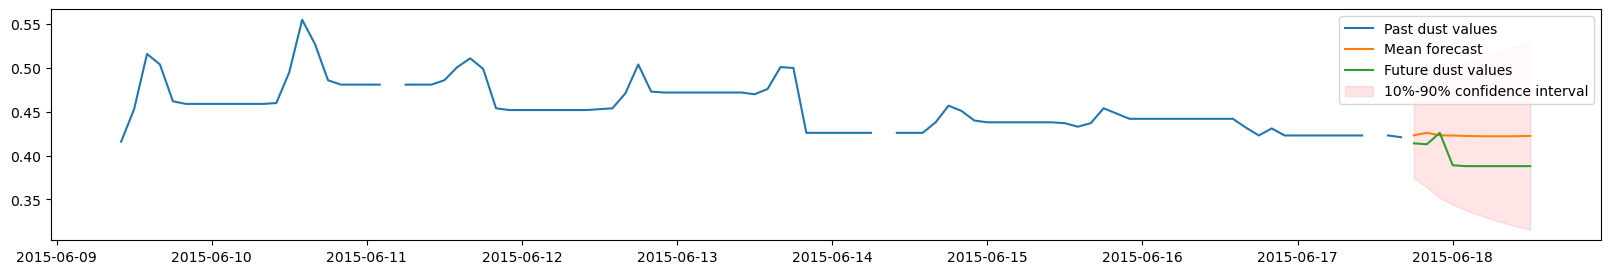

In [15]:
from plot_utils import plot_forecast

TIME_SERIES_ID: str = "dust"

plot_forecast(training_time_series, testing_time_series, training_predictions, TIME_SERIES_ID,
    PREDICTION_LENGTH, training_values=100)

## Model Evaluation

Let's take a look at what AutoGluon tried during training, over the testing time series:

In [16]:
time_series_predictor.leaderboard(testing_time_series)

data contains missing values represented by NaN. They have been filled by carrying forward the last valid observation.
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,RecursiveTabular,-0.677121,-0.516030,1.023331,0.869977,2442.150172,7
1,DeepAR,-0.769866,-0.659675,0.514553,0.424066,1038.843778,9
2,TemporalFusionTransformer,-0.924327,-0.583317,0.299159,0.241732,1096.745205,10
3,PatchTST,-1.035410,-0.819457,0.135157,0.115832,381.834703,11
4,WeightedEnsemble,-1.234526,-0.445982,18.457263,20.020699,1.285093,12
5,AutoARIMA,-1.354005,-0.485143,17.556482,19.277514,13.096032,6
6,SeasonalNaive,-1.397256,-0.480414,0.083996,0.077387,3.872310,1
7,AutoETS,-2.290253,-0.838692,12.513247,4.398480,11.625992,4
8,DynamicOptimizedTheta,-2.789396,-3.099582,5.985114,1.031381,6.292781,5
9,CrostonSBA,-5.051286,-4.514151,0.939697,0.090466,5.435308,2
